In [989]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as st
from theano import shared

plt.style.use('seaborn-darkgrid')

In [990]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

def scale_x(x, k, x0, y0):
    return k*(x-x0) + np.log(y0/(1-y0)) 

x0 = 3.5; y0 = 0.8; k = 1.6

In [991]:
n = 4000
coeff = 1.

predictors = np.random.uniform(0,10,100)
predictors_shared = shared(predictors)

x = scale_x(predictors, k, 3, y0)
outcomes = np.random.binomial(1, invlogit(x))

In [992]:
predictors_out_of_sample = np.random.uniform(2.2,4,30)
x = scale_x(predictors_out_of_sample, k, x0, y0)

outcomes_out_of_sample = np.random.binomial(1, invlogit(x))

In [993]:
with pm.Model() as model:
    pia = pm.Normal('pia', mu=x0, sigma=1)
    x = scale_x(predictors_shared, k, pia, y0)
    outcome = pm.Bernoulli('outcome', logit_p = x, observed=outcomes)
    trace = pm.sample(5000)
    mp = pm.find_MAP(include_transformed=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pia]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.


/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


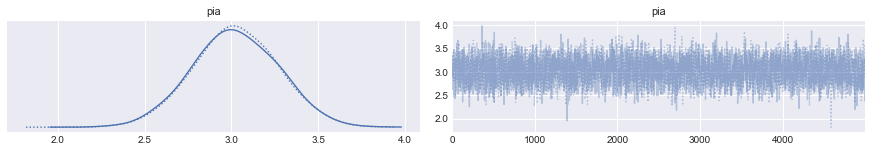

In [994]:
pm.traceplot(trace);

In [995]:
pia_update = np.mean(trace['pia'])

In [996]:
predictors_shared.set_value(predictors_out_of_sample)

In [997]:
ppc = pm.sample_posterior_predictive(trace, model=model, samples=100)

/Users/nicolle_nordmann/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [998]:
from matplotlib.ticker import StrMethodFormatter
sns.set()
blue, green, red, purple, gold, teal = sns.color_palette(n_colors=6)
pct_formatter = StrMethodFormatter('{x:.1%}')

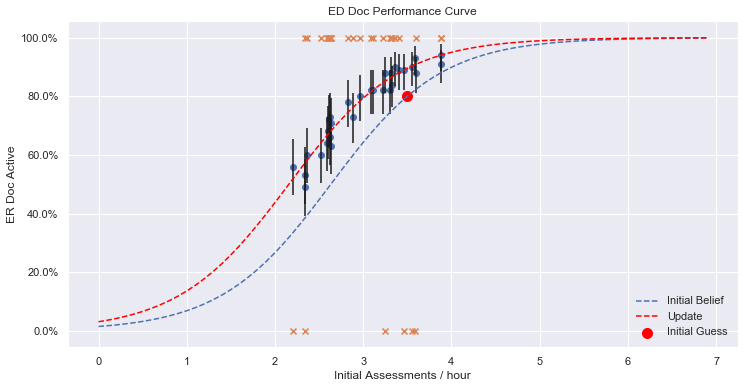

In [1005]:
fig, ax = plt.subplots(figsize=(12, 6))

β = st.beta((ppc['outcome'] == 1).sum(axis=0), (ppc['outcome'] == 0).sum(axis=0))

# estimated probability
ax.scatter(x=predictors_out_of_sample, y=β.mean())

# error bars on the estimate
plt.vlines(predictors_out_of_sample, *β.interval(0.95))

# actual outcomes
ax.scatter(x=predictors_out_of_sample, y=outcomes_out_of_sample, marker='x')

# True probabilities
x_pia = np.arange(0,7,0.1)
x_pia_belief = scale_x(x_pia, k, x0, y0)
x_pia_update = scale_x(x_pia, k, pia_update, y0)
ax.scatter(x=x0, y=y0, color='red',s=100, label='Initial Guess')
ax.plot(x_pia, invlogit(x_pia_belief), linestyle='--', label='Initial Belief')
ax.plot(x_pia, invlogit(x_pia_update), linestyle='--', label='Update',color='red')
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_xlabel('Initial Assessments / hour')
ax.set_ylabel('ER Doc Active');
ax.set_title("ED Doc Performance Curve");
ax.legend(loc='lower right')